#### git.ignore
#### create .gitignore_global
echo '.DS_Store' >> ~/.gitignore_global


#### open .gitignore_global
code ~/.gitignore_global

#### code withing .gitignore_global
env.py
.DS_Store
.ipynb_checkpoints/
__pycache__
.vscode/

#### code to exclude git from tracking .gitignore_global
git config --global core.excludesfile ~/.gitignore_global



## Imports

In [1]:
# Establish connection to Codeup database
from env import host, user, password
import os
import acquire
#import prep

# data prep
import prep

# data manipulation/
import pandas as pd
import numpy as np

# splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# modeling
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier,\
export_text,\
plot_tree
from sklearn.metrics import accuracy_score, \
confusion_matrix,\
classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

## Acquire

In [2]:
# Use functions in acquire.py to aquire the Telco churn dataset from the Codeup database in SQL
# assign the data as df
df = acquire.get_telco_data()

# verify aquisition
# df.head()

## Prep

In [3]:
# Look at df.info()
# print(df.info())

# Describe the data
# print(df.describe())

# data shape
# print(df.shape)

# look for null values
# print(df.isnull().sum())

# look for na values
# print(df.isna().sum())

##### Take away

Columns to drop
- payment_type_id 
- internet_service_type_id
- contract_type_id

Things to do
- Change datatype of total charges to float
- Change values to be all lower case and spaces to be underscores

##### Questions for data
How does living situations effect churn?
- is there a relationship between dependents and churn?
- is there a relationship between partner and churn?
- is there a relationship between senior_citizen and churn?
- is there a relationship between gender and churn?


If these variables do have relationships, is there a relationship to churn?
- is there a relationship between tenure and dependents?
- is there a relationship between dependents and total charges?
- is there a relationship between dependents and monthly charges?
- is there a relationship between tenure and partner?
- is there a relationship between partner and total charges?
- is there a relationship between partner and monthly charges?

##### clean data

In [3]:
# clean data
# create a variable for columns to drop
# cols_to_drop = ['payment_type_id', 'internet_service_type_id', 'contract_type_id']
# create a function to drop columns
# df.drop(columns = cols_to_drop)
# assign function as df
# df = df.drop(columns= cols_to_drop)
# verify columns are dropped
# df.head(1)

# create a definition to drop 'payment_type_id', 'internet_service_type_id', 'contract_type_id' if they exist
def drop_cols(df):
    cols_to_drop = ['payment_type_id'
                    , 'internet_service_type_id'
                    , 'contract_type_id']
    df = df.drop(columns=[col for col in cols_to_drop if col in df])
    return df

# verify function works
# df = drop_cols(df)
# df.head()

# create def to get dummies
def create_dummy(df):
    dummy_cols = ['churn', 'dependents', 'gender', 'partner']
    dummy = pd.concat([df,
            pd.get_dummies(df[dummy_cols], drop_first= True)], axis=1)
    return dummy.drop(['churn', 'dependents', 'gender', 'partner'], axis=1)

# verify it works
# df = create_dummy(df)

# create a def to rename dummy columns
def rename_dummies(df):
    rename_dums = df.rename(columns= {'churn_Yes':'has_churned'
                        , 'dependents_Yes':'has_dependents'
                        , 'gender_Male':'is_male'
                        , 'partner_Yes':'has_partner'})
    return rename_dums

# verify it works
# df = rename_dummies(df)

# Create a function to clean data for errors found during train
def second_clean(df):
    df.customer_id = df.index
    index_vals = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
    df = df.drop(df.columns[index_vals], axis=1)
    df['baseline'] = 0
    df.has_dependents = df.has_dependents.astype(str)
    df.has_churned = df.has_churned.astype(str)
    df.has_partner = df.has_partner.astype(str)
    df.is_male = df.is_male.astype(str)
    df.baseline = df.baseline.astype(str)
    df.customer_id = df.customer_id.astype(str)
    return df

#df = second_clean(df)
# df.info()

# create a final function that applies drop_cols and to_float to the dataframe 
def clean_data(df):
    a = drop_cols(df)
    b = create_dummy(a)
    c = rename_dummies(b)
    d = second_clean(c)
    return d
# verify
df = clean_data(df)
# df


# split data
train, test = train_test_split(df
                               , test_size=.2
                               , random_state=123
                               , stratify=df.has_churned)
train, validate = train_test_split(train
                                  , test_size=.3
                                  , random_state=123
                                  , stratify=train.has_churned)

# validate split
# print(f'train -> {train.shape}')
# print(f'validate -> {validate.shape}')
# print(f'test -> {test.shape}')

# create train, validate, test function
def split_data(df):
    train, test = train_test_split(df
                               , test_size=.2
                               , random_state=123
                               , stratify=df.has_churned)
    train, validate = train_test_split(train
                                , test_size=.3
                                , random_state=123
                                , stratify=train.has_churned)
    return train, validate, test

# validate function split data
# train, validate, test = split_data(df)

# print(f'train -> {train.shape}')
# print(f'validate -> {validate.shape}')
# print(f'test -> {test.shape}')

# create a function that cleans and preps data
def prep_telco(df):
    df = clean_data(df)
    train, validate, test = split_data(df)
    return train, validate, test

# validate function works
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (3943, 6)
validate -> (1691, 6)
test -> (1409, 6)


##### Split data

## Modeling

In [8]:
# identify the baseline value
# train.has_churned.value_counts()

In [4]:
# variables for later
X_cols = train.columns.drop('has_churned').to_list()
y_col = 'has_churned'

# create x and y values
X_train = train.drop(columns=['has_churned'])
y_train = train.has_churned

X_validate = validate.drop(columns=['has_churned'])
y_validate = validate.has_churned

X_test = test.drop(columns=['has_churned'])
y_test = test.has_churned

##### Decision Tree

[Text(0.5, 0.875, 'has_dependents <= 0.5\ngini = 0.39\nsamples = 3943\nvalue = [2897, 1046]\nclass = 0'),
 Text(0.25, 0.625, 'has_partner <= 0.5\ngini = 0.431\nsamples = 2730\nvalue = [1871, 859]\nclass = 0'),
 Text(0.125, 0.375, 'customer_id <= 62.0\ngini = 0.454\nsamples = 1811\nvalue = [1179, 632]\nclass = 0'),
 Text(0.0625, 0.125, 'gini = 0.165\nsamples = 11\nvalue = [10, 1]\nclass = 0'),
 Text(0.1875, 0.125, 'gini = 0.455\nsamples = 1800\nvalue = [1169, 631]\nclass = 0'),
 Text(0.375, 0.375, 'is_male <= 0.5\ngini = 0.372\nsamples = 919\nvalue = [692, 227]\nclass = 0'),
 Text(0.3125, 0.125, 'gini = 0.332\nsamples = 442\nvalue = [349, 93]\nclass = 0'),
 Text(0.4375, 0.125, 'gini = 0.404\nsamples = 477\nvalue = [343, 134]\nclass = 0'),
 Text(0.75, 0.625, 'customer_id <= 4907.0\ngini = 0.261\nsamples = 1213\nvalue = [1026, 187]\nclass = 0'),
 Text(0.625, 0.375, 'customer_id <= 2914.5\ngini = 0.285\nsamples = 865\nvalue = [716, 149]\nclass = 0'),
 Text(0.5625, 0.125, 'gini = 0.25\nsamp

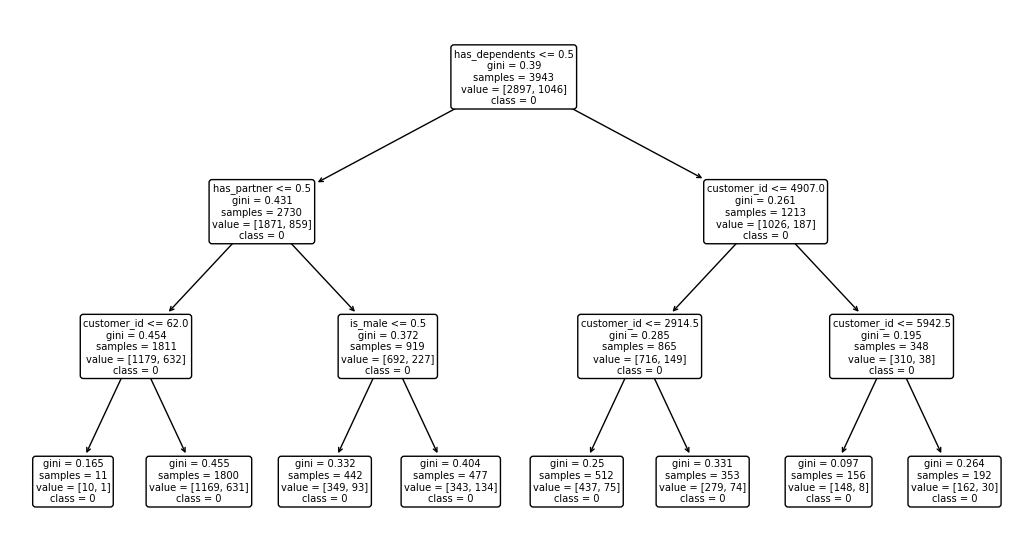

In [5]:
# create object
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

# fit model
clf = clf.fit(X_train, y_train)

# visuaalize decision tree
plt.figure(figsize=(13, 7))
plot_tree(clf
          , feature_names=X_train.columns
          , class_names=clf.classes_
          , rounded=True)

In [6]:
# create prediction on train observations
y_pred = clf.predict(X_train)
print(y_pred[0:5])

# estimate probability of churn and no churn
y_pred_proba = clf.predict_proba(X_train)
print(y_pred_proba[0:5])

['0' '0' '0' '0' '0']
[[0.78959276 0.21040724]
 [0.71907757 0.28092243]
 [0.78959276 0.21040724]
 [0.64944444 0.35055556]
 [0.71907757 0.28092243]]


##### Evaluate Model

In [7]:
# accuracy of decision tree
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

# classification report
print(f'\nclassification report for training set: \n{classification_report(y_train, y_pred)}')

# value counts
print(f'\nvalue counts for training set: \n{y_train.value_counts()}')

# confusion matrix
print(f'\nconfusion matrix for training set: \n{confusion_matrix(y_train, y_pred)}')

labels = sorted(y_train.unique())
con_mat = pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)
con_mat

Accuracy of Decision Tree classifier on training set: 0.73

classification report for training set: 
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      2897
           1       0.00      0.00      0.00      1046

    accuracy                           0.73      3943
   macro avg       0.37      0.50      0.42      3943
weighted avg       0.54      0.73      0.62      3943


value counts for training set: 
0    2897
1    1046
Name: has_churned, dtype: int64

confusion matrix for training set: 
[[2897    0]
 [1046    0]]


,0,1
0,2897,0
1,1046,0


##### Evaluate Model with Validate

In [10]:
# Produce y_predictions from the X_validate
y_pred = clf.predict(X_validate)

# Accuracy of decision tree
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
      .format(clf.score(X_validate, y_validate)))

# classification report for validate dataset
print(f'\nClassification Report for Validate Dataset: \n{classification_report(y_validate, y_pred)}')

# value counts for validate dataset
print(f'\nValue Counts for Validate Dataset: \n{y_validate.value_counts()}')

# confusion matrix
print(f'\nConfusion Matrix for Validate Set: \n{confusion_matrix(y_validate, y_pred)}')

labels = sorted(y_validate.unique())
con_mat = pd.DataFrame(confusion_matrix(y_validate, y_pred), index=labels, columns=labels)
con_mat

Accuracy of Decision Tree classifier on validate set: 0.73

Classification Report for Validate Dataset: 
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1242
           1       0.00      0.00      0.00       449

    accuracy                           0.73      1691
   macro avg       0.37      0.50      0.42      1691
weighted avg       0.54      0.73      0.62      1691


Value Vounts for Validate Dataset: 
0    1242
1     449
Name: has_churned, dtype: int64

Confusion Matrix for Validate Set: 
[[1242    0]
 [ 449    0]]


,0,1
0,1242,0
1,449,0


##### Evaluate model with Test

In [12]:
# Produce y_predictions from the X_test
y_pred = clf.predict(X_test)

# Accuracy of decision tree
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
      .format(clf.score(X_test, y_test)))

# classification report for test dataset
print(f'\nClassification Report for Test Dataset: \n{classification_report(y_test, y_pred)}')

# value counts for test dataset
print(f'\nValue Counts for Test Dataset: \n{y_test.value_counts()}')

# confusion matrix
print(f'\nConfusion Matrix for Test Set: \n{confusion_matrix(y_test, y_pred)}')

labels = sorted(y_test.unique())
con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), index=labels, columns=labels)
con_mat

Accuracy of Decision Tree classifier on validate set: 0.73

Classification Report for Test Dataset: 
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409


Value Counts for Test Dataset: 
0    1035
1     374
Name: has_churned, dtype: int64

Confusion Matrix for Test Set: 
[[1035    0]
 [ 374    0]]


,0,1
0,1035,0
1,374,0


### Random Forest

In [45]:
# make a random forest
rf = RandomForestClassifier(min_samples_leaf=3,
                            max_depth=10,
                            random_state=1349)
# fit the train data
rf.fit(X_train, y_train)

# make prediction for X_train
y_pred = rf.predict(X_train)

# accuracy of random forest for train
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

# classification report for train dataset
print(f'\nClassification Report for Test Dataset: \n{classification_report(y_train, y_pred)}')

# value counts for train dataset
print(f'\nValue Counts for Train Dataset: \n{y_train.value_counts()}')

# confusion matrix
print(f'\nConfusion Matrix for Train Set: \n{confusion_matrix(y_train, y_pred)}')

con_mat = confusion_matrix(y_train, y_pred)
rubric = pd.DataFrame(
    {'y_pred': ['True Negative', 'False Negative'],
     'y_train': ['False Positive', 'True Positive']
    }, index=['actual_0','actual_1']
)

TN, FP, FN, TP = con_mat.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
TPR = recall = TP / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (FP + TN)
FNR = FN / (FN + TP)
precision =  TP / (TP + FP)
f1 =  2 * ((precision * recall) / ( precision + recall))
support_0 = train[train.has_churned == 0].shape[0]
support_1 = train[train.has_churned == 1].shape[0]
print((f'\nAccuracy: {accuracy} \nTPR: {TPR} \nFPR: {FPR} \nTNR: {TNR} \nFNR: {FNR} \nPrecision: {precision} \nRecall: {recall} \nf1: {f1} \nsupport_0: {support_0} \nsupport_1: {support_1}'))

rubric + ': ' + con_mat.astype(str)

Accuracy of random forest classifier on training set: 0.76

Classification Report for Test Dataset: 
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      2897
           1       0.94      0.10      0.18      1046

    accuracy                           0.76      3943
   macro avg       0.85      0.55      0.52      3943
weighted avg       0.80      0.76      0.68      3943


Value Counts for Train Dataset: 
0    2897
1    1046
Name: has_churned, dtype: int64

Confusion Matrix for Train Set: 
[[2890    7]
 [ 939  107]]

Accuracy: 0.7600811564798376 
TPR: 0.1022944550669216 
FPR: 0.002416292716603383 
TNR: 0.9975837072833966 
FNR: 0.8977055449330784 
Precision: 0.9385964912280702 
Recall: 0.1022944550669216 
f1: 0.18448275862068966 
support_0: 0 
support_1: 0


,y_pred,y_train
actual_0,True Negative: 2890,False Positive: 7
actual_1,False Negative: 939,True Positive: 107


##### Evaluate model with validate

In [44]:
# fit the validate data
rf.fit(X_validate, y_validate)

# Produce y_predictions from the X_validate
y_pred = rf.predict(X_validate)

# Accuracy of random forest
print('Accuracy of Random Forest classifier on validate set: {:.2f}'
      .format(rf.score(X_validate, y_validate)))

# classification report for validate dataset
print(f'\nClassification Report for Validate Dataset: \n{classification_report(y_validate, y_pred)}')

# value counts for validate dataset
print(f'\nValue Counts for Validate Dataset: \n{y_validate.value_counts()}')

# confusion matrix
print(f'\nConfusion Matrix for Validate Set: \n{confusion_matrix(y_validate, y_pred)}')

con_mat = confusion_matrix(y_validate, y_pred)
rubric = pd.DataFrame(
    {'y_pred': ['True Negative', 'False Negative'],
     'y_validate': ['False Positive', 'True Positive']
    }, index=['actual_0','actual_1']
)

TN, FP, FN, TP = con_mat.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
TPR = recall = TP / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (FP + TN)
FNR = FN / (FN + TP)
precision =  TP / (TP + FP)
f1 =  2 * ((precision * recall) / ( precision + recall))
support_0 = validate[validate.has_churned == 0].shape[0]
support_1 = validate[validate.has_churned == 1].shape[0]
print((f'\nAccuracy: {accuracy} \nTPR: {TPR} \nFPR: {FPR} \nTNR: {TNR} \nFNR: {FNR} \nPrecision: {precision} \nRecall: {recall} \nf1: {f1} \nsupport_0: {support_0} \nsupport_1: {support_1}'))

rubric + ': ' + con_mat.astype(str)

Accuracy of Random Forest classifier on validate set: 0.77

Classification Report for Validate Dataset: 
              precision    recall  f1-score   support

           0       0.77      0.99      0.86      1242
           1       0.85      0.17      0.28       449

    accuracy                           0.77      1691
   macro avg       0.81      0.58      0.57      1691
weighted avg       0.79      0.77      0.71      1691


Value Counts for Validate Dataset: 
0    1242
1     449
Name: has_churned, dtype: int64

Confusion Matrix for Validate Set: 
[[1229   13]
 [ 374   75]]

Accuracy: 0.7711413364872857 
TPR: 0.16703786191536749 
FPR: 0.010466988727858293 
TNR: 0.9895330112721417 
FNR: 0.8329621380846325 
Precision: 0.8522727272727273 
Recall: 0.16703786191536749 
f1: 0.2793296089385475 
support_0: 0 
support_1: 0


,y_pred,y_validate
actual_0,True Negative: 1229,False Positive: 13
actual_1,False Negative: 374,True Positive: 75


##### Evaluate on Test

In [43]:
# fit the test data
rf.fit(X_test, y_test)

# make prediction for X_test
y_pred = rf.predict(X_test)

# accuracy of random forest for test
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

# classification report for test dataset
print(f'\nClassification Report for Test Dataset: \n{classification_report(y_test, y_pred)}')

# value counts for test dataset
print(f'\nValue Counts for Test Dataset: \n{y_test.value_counts()}')

# confusion matrix
print(f'\nConfusion Matrix for Test Set: \n{confusion_matrix(y_test, y_pred)}')

con_mat = confusion_matrix(y_test, y_pred)
rubric = pd.DataFrame(
    {'y_pred': ['True Negative', 'False Negative'],
     'y_test': ['False Positive', 'True Positive']
    }, index=['actual_0','actual_1']
)

TN, FP, FN, TP = con_mat.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
TPR = recall = TP / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (FP + TN)
FNR = FN / (FN + TP)
precision =  TP / (TP + FP)
f1 =  2 * ((precision * recall) / ( precision + recall))
support_0 = test[test.has_churned == 0].shape[0]
support_1 = test[test.has_churned == 1].shape[0]
print((f'\nAccuracy: {accuracy} \nTPR: {TPR} \nFPR: {FPR} \nTNR: {TNR} \nFNR: {FNR} \nPrecision: {precision} \nRecall: {recall} \nf1: {f1} \nsupport_0: {support_0} \nsupport_1: {support_1}'))

rubric + ': ' + con_mat.astype(str)

Accuracy of random forest classifier on test set: 0.80

Classification Report for Test Dataset: 
              precision    recall  f1-score   support

           0       0.79      0.98      0.88      1035
           1       0.86      0.29      0.43       374

    accuracy                           0.80      1409
   macro avg       0.82      0.64      0.65      1409
weighted avg       0.81      0.80      0.76      1409


Value Counts for Test Dataset: 
0    1035
1     374
Name: has_churned, dtype: int64

Confusion Matrix for Test Set: 
[[1017   18]
 [ 266  108]]

Accuracy: 0.7984386089425124 
TPR: 0.2887700534759358 
FPR: 0.017391304347826087 
TNR: 0.9826086956521739 
FNR: 0.7112299465240641 
Precision: 0.8571428571428571 
Recall: 0.2887700534759358 
f1: 0.432 
support_0: 0 
support_1: 0


,y_pred,y_test
actual_0,True Negative: 1017,False Positive: 18
actual_1,False Negative: 266,True Positive: 108


In [46]:
# I perhaps would do the same thing I did before with a loop!
rf_model_dict = {}
for i in [pair for pair in zip(range(1,10), 
                                range(10,1,-1))]:
    clf = RandomForestClassifier(min_samples_leaf=i[0],
                                 max_depth=i[1])
    clf.fit(X_train, y_train)
    # make a dictionary inside of my model_dictionary
    rf_model_dict[f'rf_{i[0]}'] =  {}
    # in the sub-dictionary:
    # assign the model object
    rf_model_dict[f'rf_{i[0]}']['model'] = clf
    #assign the train score
    rf_model_dict[f'rf_{i[0]}']['train_score'] = \
    clf.score(X_train, y_train)
    # assign the validate score
    rf_model_dict[f'rf_{i[0]}']['val_score'] = \
    clf.score(X_validate, y_validate)
    # assign the validation dropoff
    rf_model_dict[f'rf_{i[0]}']['val_diff'] = \
    clf.score(X_train, y_train) - clf.score(X_validate, y_validate)

In [47]:
rf_model_dict

{'rf_1': {'model': RandomForestClassifier(max_depth=10),
  'train_score': 0.7699721024600558,
  'val_score': 0.7238320520402128,
  'val_diff': 0.046140050419842926},
 'rf_2': {'model': RandomForestClassifier(max_depth=9, min_samples_leaf=2),
  'train_score': 0.7532335784935329,
  'val_score': 0.7261975162625666,
  'val_diff': 0.02703606223096633},
 'rf_3': {'model': RandomForestClassifier(max_depth=8, min_samples_leaf=3),
  'train_score': 0.7425817905148364,
  'val_score': 0.7285629804849202,
  'val_diff': 0.014018810029916229},
 'rf_4': {'model': RandomForestClassifier(max_depth=7, min_samples_leaf=4),
  'train_score': 0.7370022825259954,
  'val_score': 0.7315198107628622,
  'val_diff': 0.005482471763133212},
 'rf_5': {'model': RandomForestClassifier(max_depth=6, min_samples_leaf=5),
  'train_score': 0.7347197565305605,
  'val_score': 0.7344766410408042,
  'val_diff': 0.00024311548975630703},
 'rf_6': {'model': RandomForestClassifier(max_depth=5, min_samples_leaf=6),
  'train_score': 

In [48]:
max_score = 0
for model in rf_model_dict:
    if rf_model_dict[model]['val_score'] > max_score:
        max_score = rf_model_dict[model]['val_score']
        model_name = model


In [49]:
max_score

0.7344766410408042

In [50]:
model

'rf_9'

In [51]:
rf_model_dict['rf_9']['model']

RandomForestClassifier(max_depth=2, min_samples_leaf=9)

In [52]:
len([0 for i in range(0, validate.shape[0])])

1691

In [60]:
# Prediction DataFrame!
pred_df = pd.DataFrame(
    {
        'baseline': [0 for i in range(
        0, validate.shape[0])],
        'y_true': y_validate.values
    }
)

for model in rf_model_dict:
    model_preds = rf_model_dict[model]['model'].predict(X_validate)
    pred_df[model] = model_preds
    
pred_df

,baseline,y_true,rf_1,rf_2,rf_3,rf_4,rf_5,rf_6,rf_7,rf_8,rf_9
0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1686,0,0,0,0,0,0,0,0,0,0,0
1687,0,1,0,0,0,0,0,0,0,0,0
1688,0,0,0,0,0,0,0,0,0,0,0
1689,0,0,0,0,0,0,0,0,0,0,0


In [64]:
rf_model_dict.keys()

dict_keys(['rf_1', 'rf_2', 'rf_3', 'rf_4', 'rf_5', 'rf_6', 'rf_7', 'rf_8', 'rf_9'])

In [65]:
rf_model_dict['rf_1'].keys()


dict_keys(['model', 'train_score', 'val_score', 'val_diff'])

In [66]:
[rf_model_dict[model]['train_score'] 
 for model in rf_model_dict]


[0.7745371544509256,
 0.7517118944965762,
 0.7433426325133148,
 0.7354805985290388,
 0.7347197565305605,
 0.7347197565305605,
 0.7347197565305605,
 0.7347197565305605,
 0.7347197565305605]

In [61]:
accuracy_df = pd.DataFrame(
 {
     'model':[model for model in rf_model_dict],
     'train_accuracy':[rf_model_dict[model]['train_score'] for model in rf_model_dict],
     'val_accuracy': [rf_model_dict[model]['val_score'] for model in rf_model_dict],
     'diff': [rf_model_dict[model]['val_diff'] for model in rf_model_dict]
 }
)
accuracy_df

,model,train_accuracy,val_accuracy,diff
0,rf_1,0.769972,0.723832,0.046140
1,rf_2,0.753234,0.726198,0.027036
2,rf_3,0.742582,0.728563,0.014019
3,rf_4,0.737002,0.731520,0.005482
4,rf_5,0.734720,0.734477,0.000243
5,rf_6,0.734720,0.734477,0.000243
6,rf_7,0.734720,0.734477,0.000243
7,rf_8,0.734720,0.734477,0.000243
8,rf_9,0.734720,0.734477,0.000243


<AxesSubplot:title={'center':'performance over depth of RF'}>

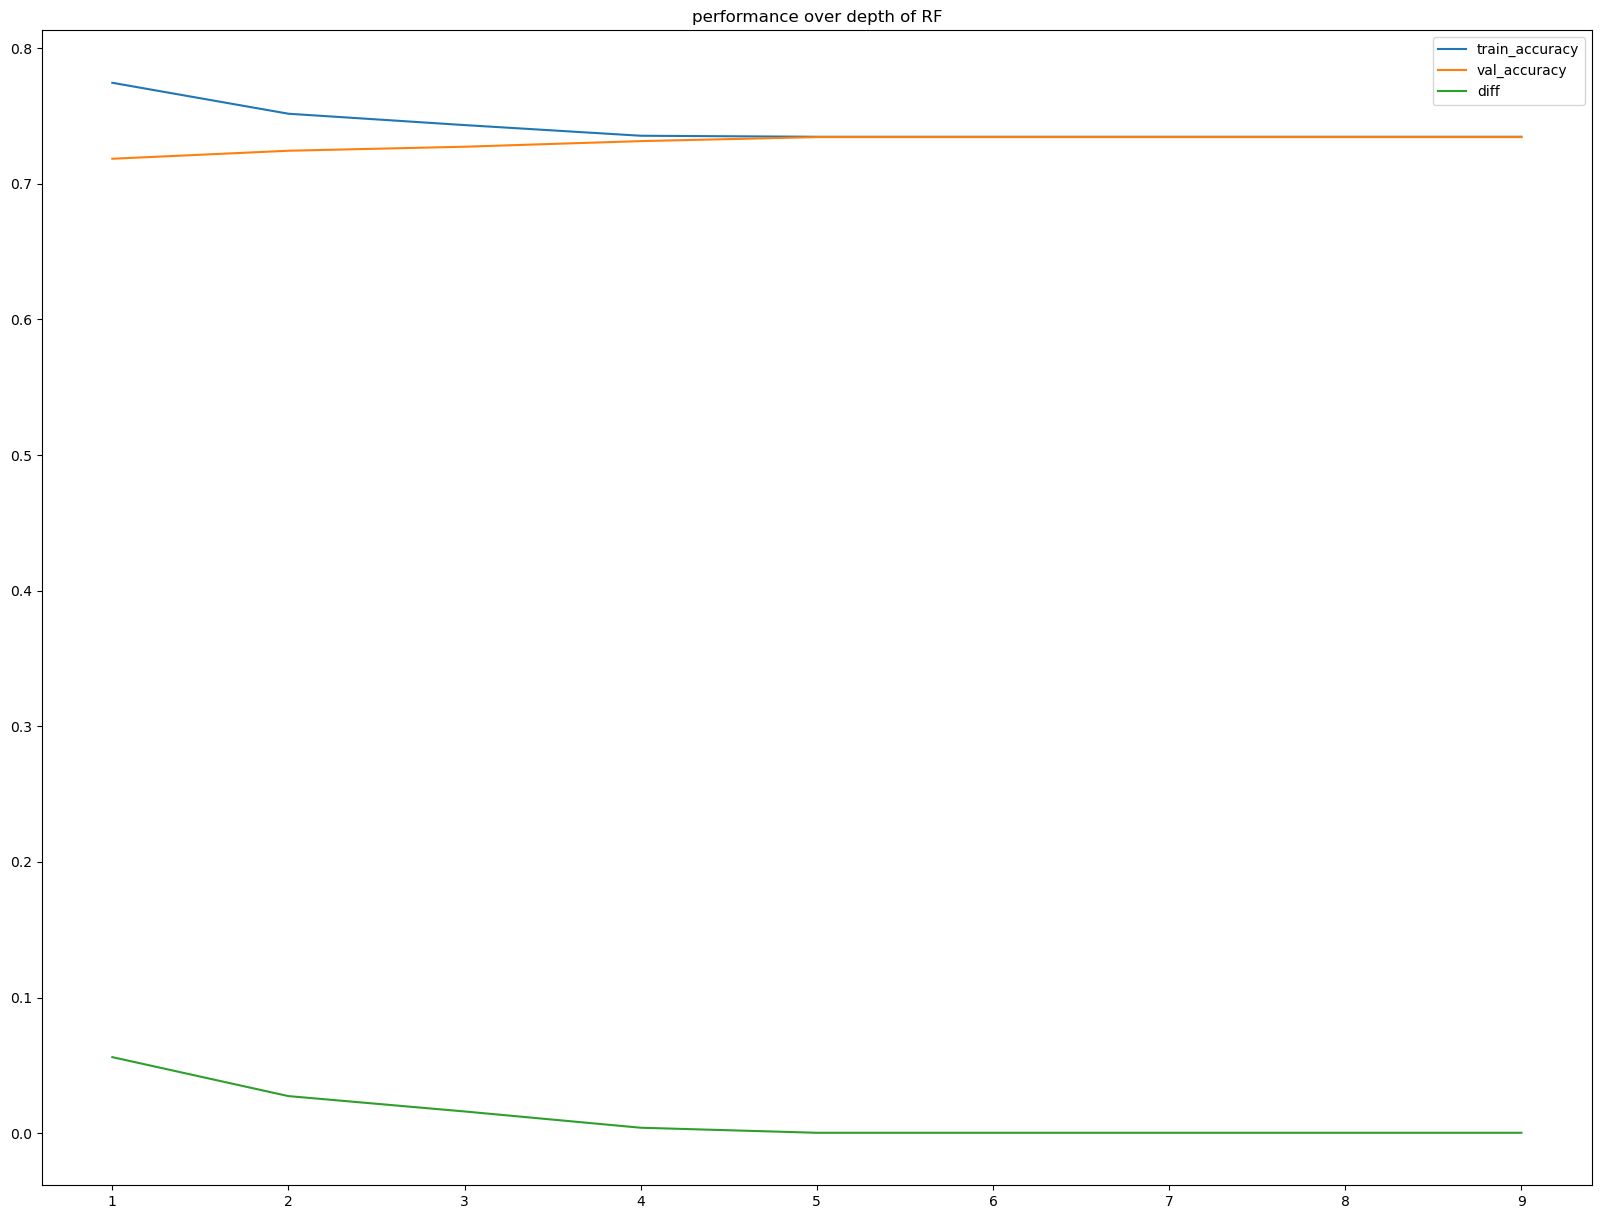

In [70]:
accuracy_df.set_index(accuracy_df.index + 1).plot(title='performance over depth of RF', figsize=(20,15))

In [71]:
model_name

'rf_5'

In [72]:
rf_model_dict['rf_2']

{'model': RandomForestClassifier(max_depth=9, min_samples_leaf=2),
 'train_score': 0.7517118944965762,
 'val_score': 0.7244234180958014,
 'val_diff': 0.027288476400774808}

In [73]:
test_preds = rf_model_dict['rf_2']['model'].predict(
    test[X_cols])
test_score = rf_model_dict['rf_2']['model'].score(
    test[X_cols],test[y_col])

In [74]:
test_score

0.7253371185237757

##### Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression

In [69]:
# from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.7347197565305605

In [66]:
print('Coefficient: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)

Coefficient: 
 [[-1.65875776e-05 -4.53263793e-01 -2.41463290e-01 -5.56195842e-01
   0.00000000e+00]]
Intercept: 
 [-0.47455424]


In [71]:
y_pred = lr.predict(X_train)
y_pred_proba = lr.predict_proba(X_train)
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(lr.score(X_train, y_train)))
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

Accuracy of Logistic Regression classifier on training set: 0.73
[[2897    0]
 [1046    0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      2897
           1       0.00      0.00      0.00      1046

    accuracy                           0.73      3943
   macro avg       0.37      0.50      0.42      3943
weighted avg       0.54      0.73      0.62      3943

